# Unsupervised Machine Learning II: Additional Applications of Clustering Analyses

This training module was developed by Alexis Payton, MS, Lauren E. Koval, and Dr. Julia E. Rager

Spring 2024

## Introduction to Training Module
ADD WORDS ABOUT DIFFERENCES BETWEEN THIS MODULE AND THE PREVIOUS ONE 

k-means vs. hierarchical

### Deriving the Optimal Number of Clusters
There are lots of methods...
+ **Elbow Method**
+ **Siloheutte Method**

ADD WORDS ABOUT THE DATASET TO BE USED

Let's read and in and view the datasets we'll be working with.

### Installing required R packagesIf you already have these packages installed, you can skip this step, or you can run the below code which checks installation status for you

In [34]:
if (!requireNamespace("vegan"))
  install.packages("vegan");
if (!requireNamespace("ggrepel"))
  install.packages("ggrepel");
if (!requireNamespace("dendextend"))
  install.packages("dendextend");

Loading required namespace: dendextend

Registered S3 method overwritten by 'dendextend':
  method     from 
  rev.hclust vegan



### Loading required R packages

In [36]:
library(readxl)
library(factoextra)
library(tidyverse)
library(vegan)
library(ggrepel)
library(reshape2)
library(pheatmap)
suppressPackageStartupMessages(library(dendextend))

### Set your working directory

In [4]:
# ```{r, eval=FALSE, echo=TRUE}
# setwd("/filepath to where your input files are")
# ```

### Importing example dataset

Then let's read in our example dataset. As mentioned in the introduction, this example dataset represents chemical measurements across 12 different biomass burn scenarios, representing potential wildfire events. CHANGE!! Let's upload and view these data:

In [2]:
# Reading in files
cytokines_df = data.frame(read_excel("CytokineData_102920.xlsx", sheet = 2))
subject_info_df = data.frame(read_excel("SubjectInfo_102920.xlsx", sheet = 2))

# Viewing data 
head(cytokines_df)
head(subject_info_df)

,Original_Identifier,Protein,Conc,Conc_pslog2,Compartment,SubjectNo,Group,SubjectID
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,E_C_F_002,IFNg,17.642316,4.220509,NELF,1,NS,NS_1
2,E_C_F_002,IL10,2.873724,1.953721,NELF,1,NS,NS_1
3,E_C_F_002,IL12p70,1.625272,1.392467,NELF,1,NS,NS_1
4,E_C_F_002,IL13,36.117692,5.214035,NELF,1,NS,NS_1
5,E_C_F_002,IL1b,104.409217,6.719857,NELF,1,NS,NS_1
6,E_C_F_002,IL6,21.159536,4.469856,NELF,1,NS,NS_1


,SubjectNo,Group,SubjectID,Race,Ethnicity,Sex,Age,BMI,Serum_Cotinine
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,1,NS,NS_1,W,NH,F,28,37.67,NA
2,2,NS,NS_2,O,H,F,33,35.00,NA
3,3,NS,NS_3,W,NH,F,25,18.70,NA
4,4,NS,NS_4,W,NH,F,26,23.00,NA
5,5,NS,NS_5,As,NH,F,25,24.70,NA
6,6,NS,NS_6,AA,NH,F,42,34.60,NA


## Training Module's Environmental Health QuestionsThis training module was specifically developed to answer the following environmental health questions:1. What are the optimal number of ***k*-means** clusters the cytokines can be grouped into that were derived from nasal epithelium fluid in non-smokers?
2. What are the optimal number of **hierarchical** clusters the cytokines can be grouped into that were derived from nasal epithelium fluid in non-smokers? How do the hierarchical cluster assignments compare to the *k*-means cluster assignments?3. idk yet?4. idk?

To answer the first envirionmental health question, let's start by filtering to include only NELF derived samples and non-smokers.

In [5]:
baseline_df = cytokines_df %>%
    filter(Group == "NS", Compartment == "NELF") #%>%
    #select(

head(baseline_df)

,Original_Identifier,Protein,Conc,Conc_pslog2,Compartment,SubjectNo,Group,SubjectID
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,E_C_F_002,IFNg,17.642316,4.220509,NELF,1,NS,NS_1
2,E_C_F_002,IL10,2.873724,1.953721,NELF,1,NS,NS_1
3,E_C_F_002,IL12p70,1.625272,1.392467,NELF,1,NS,NS_1
4,E_C_F_002,IL13,36.117692,5.214035,NELF,1,NS,NS_1
5,E_C_F_002,IL1b,104.409217,6.719857,NELF,1,NS,NS_1
6,E_C_F_002,IL6,21.159536,4.469856,NELF,1,NS,NS_1


The functions we require us to cast the data wider, which we will do now. 

In [6]:
wider_baseline_df = reshape2::dcast(baseline_df, SubjectID ~ Protein, value.var = "Conc_pslog2") %>% 
  column_to_rownames("SubjectID")

head(wider_baseline_df)

,Eotaxin,Eotaxin3,Fractalkine,I309,IFNg,IL10,IL12p70,IL13,IL17B,IL17D,⋯,IL6,IL8,IP10,ITAC,MCP1,MIG,MIP1a,MIP1b,TARC,TNFa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NS_1,7.215729,4.396783,13.58455,0.000000,4.220509,1.953721,1.3924669,5.214035,5.670001,5.7285643,⋯,4.469856,14.85407,12.670258,11.211643,8.943624,14.365531,5.236115,6.869259,4.972066,3.903196
NS_10,8.016193,4.006488,13.67988,0.000000,1.990018,1.145162,2.0678450,3.878793,5.793669,2.2508408,⋯,3.300551,14.72563,11.806168,3.640216,8.157660,9.774213,6.009427,7.363432,4.893786,2.627590
NS_11,6.264252,5.289509,12.95222,0.000000,2.656691,1.348623,2.2078380,4.130891,4.858181,0.7247419,⋯,3.183762,15.49819,12.204282,3.684703,8.038883,9.366035,6.016487,6.272712,3.558072,3.009646
NS_12,6.938344,3.597945,13.46465,0.000000,3.439682,1.801954,2.1397923,5.313787,0.000000,0.0000000,⋯,4.478494,14.99239,11.169441,4.035557,7.101491,9.111526,5.925305,6.583509,4.385354,4.354130
NS_13,5.152683,3.051951,12.11074,0.000000,2.318340,1.176498,0.7194139,4.034806,5.179790,3.6580199,⋯,4.158730,12.98480,9.809327,6.155755,7.834706,11.631858,3.664734,4.705741,3.713002,2.716356
NS_14,7.937892,3.063025,12.78566,1.617372,3.439850,1.800412,1.2381746,4.804240,5.612285,7.2668665,⋯,4.676109,13.60216,12.825214,9.784703,6.857290,14.722907,6.202924,6.817265,4.171323,3.597219


Derving clusters...

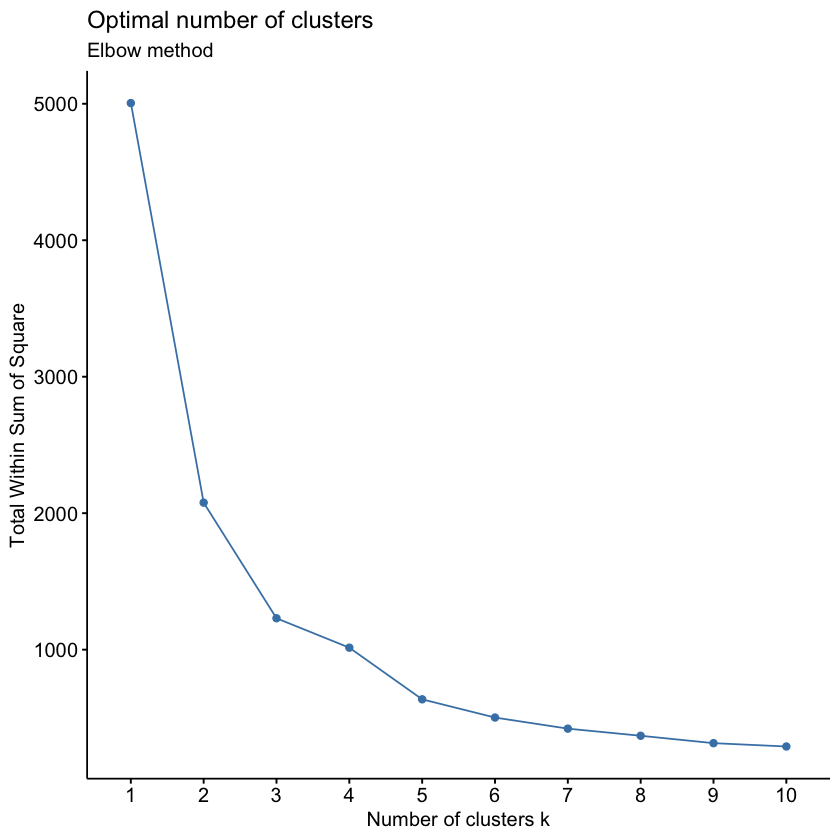

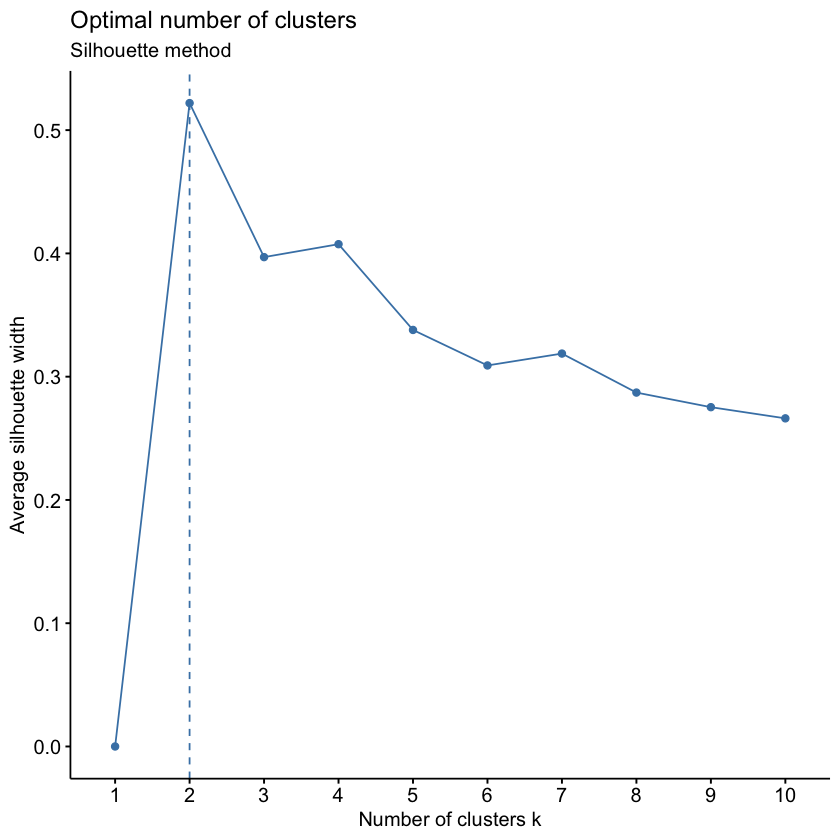

In [7]:
t_wider_baseline_df = t(wider_baseline_df)
fviz_nbclust(t_wider_baseline_df, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 3
fviz_nbclust(t_wider_baseline_df, kmeans, method = "silhouette") + 
  labs(subtitle = "Silhouette method") # suggests 2

These different methods are suggesting either 2 or 3 clusters. We can go ahead and run *k*-means to visualize the clusters and test different k's. *K*-means clusters will be visualized using the `fviz_cluster()` function.

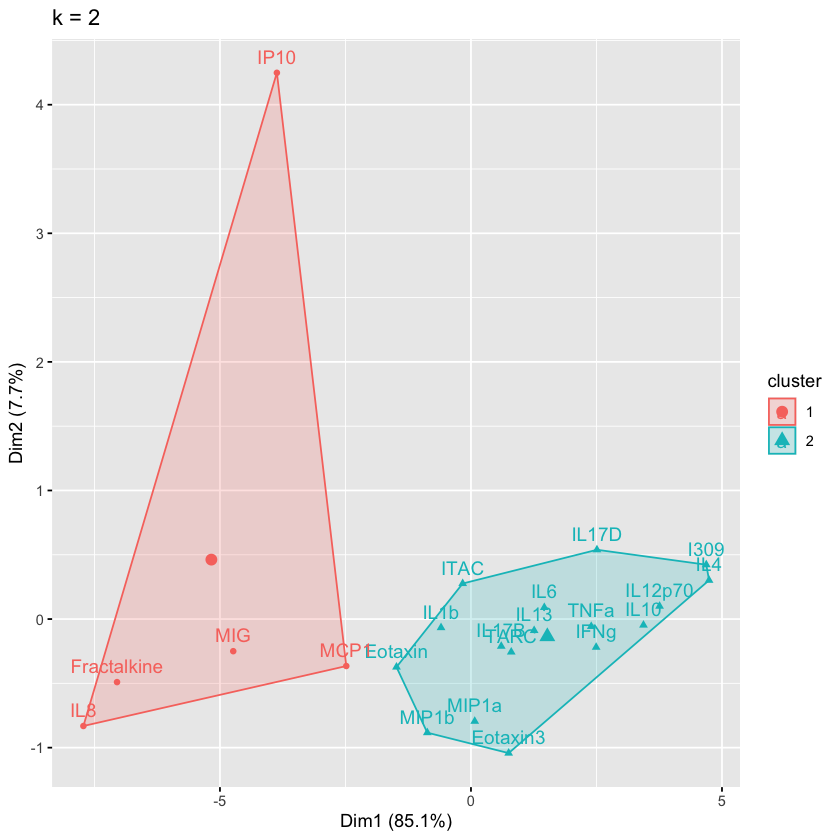

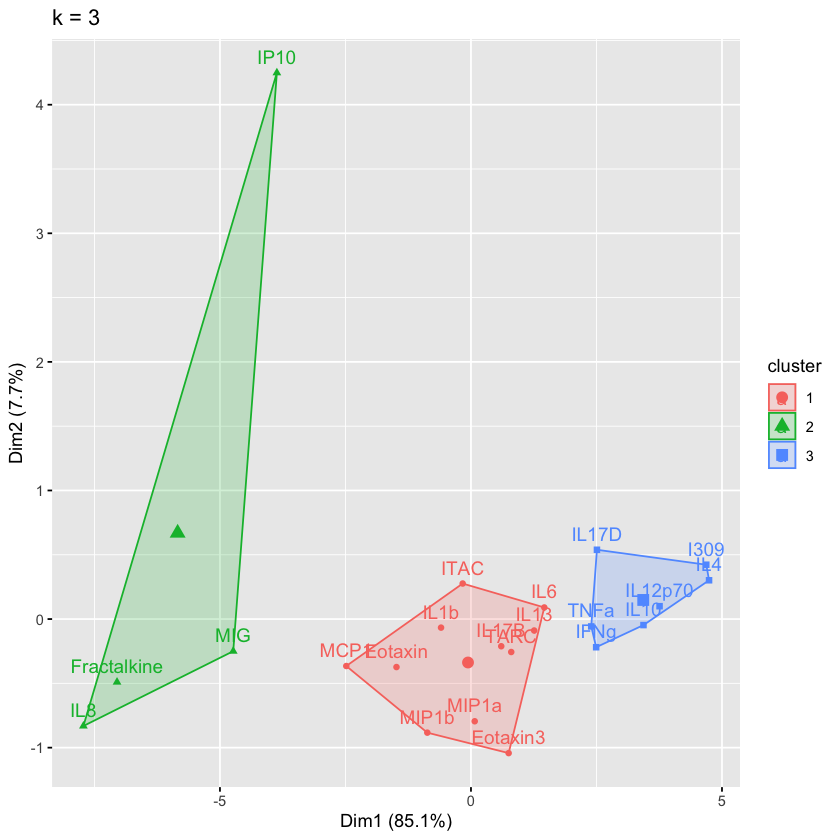

In [8]:
cluster_plots = list()

# Choosing to iterate through 2 or 3 clusters using i as our iterator
for (i in 2:3){
    # TALK ABOUT NSTART!!!
    cluster_k <- kmeans(t_wider_baseline_df, centers = i, nstart = 25)
    cluster_plots[[i]] <- fviz_cluster(cluster_k, data = t_wider_baseline_df) + ggtitle(paste0("k = ", i))
    print(cluster_plots[[i]])
}

### Answer to Environmental Health Question 1

*With this, we can answer **Environmental Health Question #1***: What are the optimal number of ***k*-means** clusters the cytokines can be grouped into that were derived from nasal epithelium fluid in non-smokers?

**Answer**: 2 or 3 clusters can be justified here, based on using the elbow or silohette method or if *k*-means happens to group cytokines together that were implicated in similar biological pathways. In the final paper, we moved forward with 3 clusters, because....

Final cluster assignment.

In [31]:
cluster_kmeans <- kmeans(t_wider_baseline_df, centers = 3, nstart = 25)
cluster_kmeans_df <- data.frame(cluster_kmeans$cluster) %>%
    # reordering the dataframe so that the cytokines are arranged by their cluster assignment
    arrange(cluster_kmeans.cluster)
colnames(cluster_kmeans_df)[1] <- "Cluster"

cluster_kmeans_df

,Cluster
,<int>
Eotaxin,1
Eotaxin3,1
IL13,1
IL17B,1
IL1b,1
IL6,1
ITAC,1
MCP1,1
MIP1a,1


## Hierarchical Clustering

Next we'll turn our attention to answering environmental health question 2: What are the optimal number of **hierarchical** clusters the cytokines can be grouped into that were derived from nasal epithelium fluid in non-smokers? How do the hierarchical cluster assignments compare to the *k*-means cluster assignments?

We'll start by using the `dist()`function to calculate the euclidean distance between the clusters followed by the `hclust()` function to obtain the hierarchical clustering assignments.

In [41]:
head(t_wider_baseline_df)

,NS_1,NS_10,NS_11,NS_12,NS_13,NS_14,NS_2,NS_3,NS_4,NS_5,NS_6,NS_7,NS_8,NS_9
Eotaxin,7.215729,8.016193,6.264252,6.938344,5.152683,7.937892,9.773407,6.12290913,5.758602,4.19868540,6.832578,7.998467,9.242464,7.127746
Eotaxin3,4.396783,4.006488,5.289509,3.597945,3.051951,3.063025,9.022390,2.50161364,2.721195,2.21084320,3.820379,5.549164,13.724108,3.553097
Fractalkine,13.584554,13.679882,12.952220,13.464652,12.110742,12.785656,14.961872,12.71538464,12.057105,10.38711624,12.917180,14.636190,14.047382,13.146599
I309,0.000000,0.000000,0.000000,0.000000,0.000000,1.617372,1.103140,0.00000000,0.000000,0.00000000,0.000000,0.000000,0.000000,0.000000
IFNg,4.220509,1.990018,2.656691,3.439682,2.318340,3.439850,4.394705,0.00000000,2.638213,0.04830196,1.914092,3.251501,4.104820,2.940248
IL10,1.953721,1.145162,1.348623,1.801954,1.176498,1.800412,2.652120,0.08945805,2.020155,0.84649523,1.119272,2.007941,2.576814,1.970627


In [58]:
# First scaling data with each subject (down columns)
scaled_df = data.frame(apply(t_wider_baseline_df, 2, scale))
rownames(scaled_df) = rownames(t_wider_baseline_df)

head(scaled_df)

,NS_1,NS_10,NS_11,NS_12,NS_13,NS_14,NS_2,NS_3,NS_4,NS_5,NS_6,NS_7,NS_8,NS_9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Eotaxin,0.1563938,0.5913460,0.20280481,0.3812918,0.04218372,0.3889166,0.5142129,0.5748344,0.3352251,0.1297382,0.6605088,0.4509596,0.5504372,0.6258899
Eotaxin3,-0.4836295,-0.3751558,-0.03031899,-0.4135856,-0.51644074,-0.7745030,0.3434700,-0.3390521,-0.4516462,-0.3710044,-0.1481961,-0.1213017,1.4999690,-0.3063521
Fractalkine,1.6023933,1.9565250,1.80232784,1.9342844,1.89246390,1.5458678,1.6938060,2.2385415,1.9669167,1.6886200,2.2940816,2.0018134,1.5684615,2.1955622
I309,-1.4818900,-1.3408820,-1.29538062,-1.2697485,-1.32801259,-1.1195175,-1.4569648,-0.9703707,-1.1565995,-0.9279215,-1.1738781,-1.4178220,-1.4077759,-1.2329735
IFNg,-0.5236512,-0.8612069,-0.65999509,-0.4512458,-0.71152186,-0.6845711,-0.7086302,-0.9703707,-0.4731435,-0.9157541,-0.6599894,-0.6581332,-0.5380823,-0.4661787
IL10,-1.0383105,-1.0648515,-0.97283813,-0.8409577,-1.01515934,-1.0758338,-1.1048056,-0.9477947,-0.6332576,-0.7146872,-0.8733797,-0.9486817,-0.8618228,-0.7190487


In [59]:
# Calculating euclidean dist
dist_matrix <- dist(scaled_df, method = 'euclidean')

# Getting clusters???
cytokines_hc = hclust(dist_matrix, method = 'average')

cytokines_hc


Call:
hclust(d = dist_matrix, method = "average")

Cluster method   : average 
Distance         : euclidean 
Number of objects: 22 


Similar to what we did above using the elbow and siloheutte methods, dendograms will be visualized to determine the optimal number of hierarchical clusters.

In [63]:
# #plot(color_branches(as.dendrogram(NLF_hc), h = 2))

# # Choosing to iterate through 2 or 3 clusters using i as our iterator
# for (i in 2:3){
#     # Coloring based upon the number of clusters we're specifying
#     plot(color_branches(as.dendrogram(cytokines_hc), h = i), main = paste0("k = ", i)) 
# }

In [73]:
# cuts the tree based upon the number of clusters specified by k
hc_assignments_df <- data.frame(cutree(cytokines_hc, k = 3)) %>%
    # reordering the dataframe so that the cytokines are arranged by their cluster assignment
    arrange(cutree.cytokines_hc..k...3.)
colnames(hc_assignments_df) = "Cluster"

# changing protein colname so it's consistent with cytokine file
#clus_df = dplyr::rename(clus_df, Cytokine = Protein)
hc_assignments_df

,Cluster
,<int>
Eotaxin,1
Eotaxin3,1
I309,1
IFNg,1
IL10,1
IL12p70,1
IL13,1
IL17B,1
IL17D,1


We can modify the clusters built from the `fviz_cluster()` function, however it's more `ggplot()`is more customizable. Therefore, the data necessary to build the plot will be extracted and fed into `ggplot()`.

EXPLAIN WHAT'S HAPPENING BELOW..but I thought k-means doesn't use PCA??

In [12]:
# First running PCA????
trythis <- stats::prcomp(t_wider_baseline_df, scale = TRUE, center = TRUE)
# Only need PC1 and PC2 for plotting, so selecting the first two columns
baseline_scores_df <- data.frame(scores(trythis)[,1:2]) 
baseline_scores_df$Cluster <- cluster_k3_df$Cluster
baseline_scores_df$Protein <- rownames(baseline_scores_df)

# Changing cluster to a character for plotting
baseline_scores_df$Cluster = as.character(baseline_scores_df$Cluster)

head(baseline_scores_df)

,PC1,PC2,Cluster,Protein
,<dbl>,<dbl>,<chr>,<chr>
Eotaxin,-1.4837936,-0.37325290,1,Eotaxin
Eotaxin3,0.7505718,-1.04251406,1,Eotaxin3
Fractalkine,-7.0500961,-0.49034208,2,Fractalkine
I309,4.6869896,0.42263944,3,I309
IFNg,2.4935464,-0.21910385,3,IFNg
IL10,3.4361668,-0.04689913,3,IL10


In [14]:
# MIGHT MAKE THIS CODE BETTER...AND REMOVE ROWNAMES
cluster_1 <- baseline_scores_df[baseline_scores_df$Cluster == 1, ][chull(baseline_scores_df %>% 
                                                                    filter(Cluster == 1)),]  # hull values for cluster 1
cluster_2 <- baseline_scores_df[baseline_scores_df$Cluster == 2, ][chull(baseline_scores_df %>% 
                                                                    filter(Cluster == 2)),]  # hull values for cluster 2
cluster_3 <- baseline_scores_df[baseline_scores_df$Cluster == 3, ][chull(baseline_scores_df %>% 
                                                                    filter(Cluster == 3)),]  # hull values for cluster 3
all_hulls_baseline <- rbind(cluster_1, cluster_2, cluster_3)
# Changing cluster to a character for plotting
all_hulls_baseline$Cluster = as.character(all_hulls_baseline$Cluster)

head(all_hulls_baseline)

,PC1,PC2,Cluster,Protein
,<dbl>,<dbl>,<chr>,<chr>
Eotaxin3,0.7505718,-1.04251406,1,Eotaxin3
MIP1b,-0.8699488,-0.88345324,1,MIP1b
MCP1,-2.4837364,-0.36522346,1,MCP1
ITAC,-0.1650598,0.27636151,1,ITAC
IL6,1.4605494,0.09012234,1,IL6
MIG,-4.7353654,-0.24986620,2,MIG


## *K*-Means Cluster Visualization

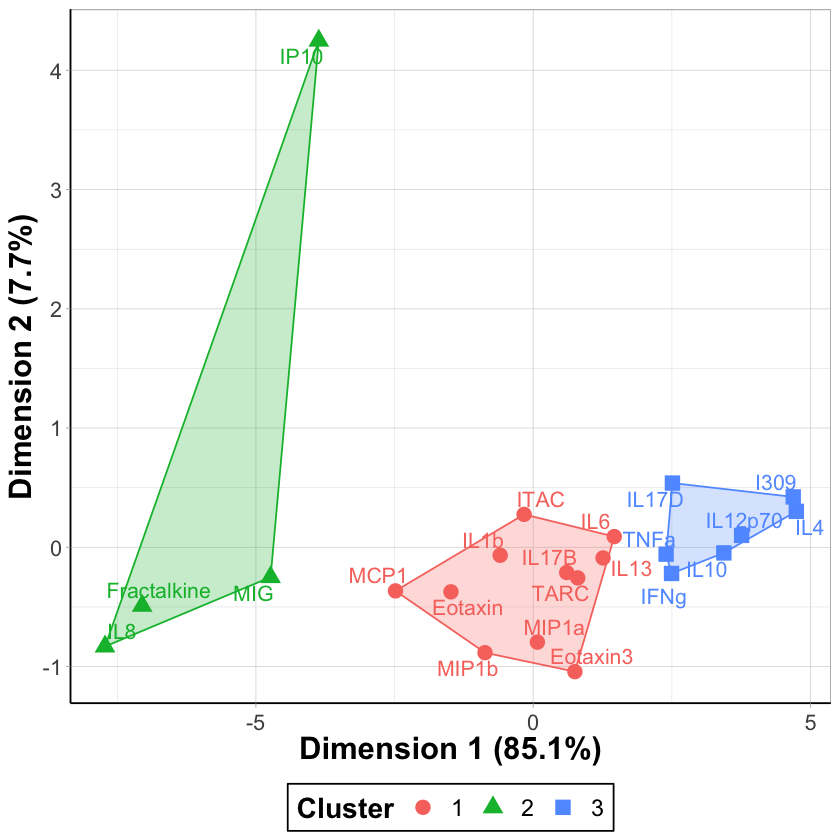

In [15]:
ggplot() + 
  geom_point(data = baseline_scores_df, aes(x = PC1, y = PC2, color = Cluster, shape = Cluster), size = 4) + 
  # adding cytokine names
  geom_text_repel(data = baseline_scores_df, aes(x = PC1, y = PC2, color = Cluster, label = Protein), 
                  show.legend = FALSE, size = 4.5) + 
  # creating polygon shapes of the clusters
  geom_polygon(data = all_hulls_baseline, aes(x = PC1, y = PC2, group = as.factor(Cluster), fill = Cluster, 
                                        color = Cluster), alpha = 0.25, show.legend = FALSE) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 17), #changes legend title
        legend.text = element_text(size = 14), #changes legend text
        legend.position = 'bottom', # moving the legend to the bottom
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'), #changes the legend background
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1 (85.1%)') + ylab('Dimension 2 (7.7%)') + #changing axis labels 

  guides(shape = guide_legend(title = "Cluster")) #removing legend for color and changing title

## Hierarchical Clustering Visualization

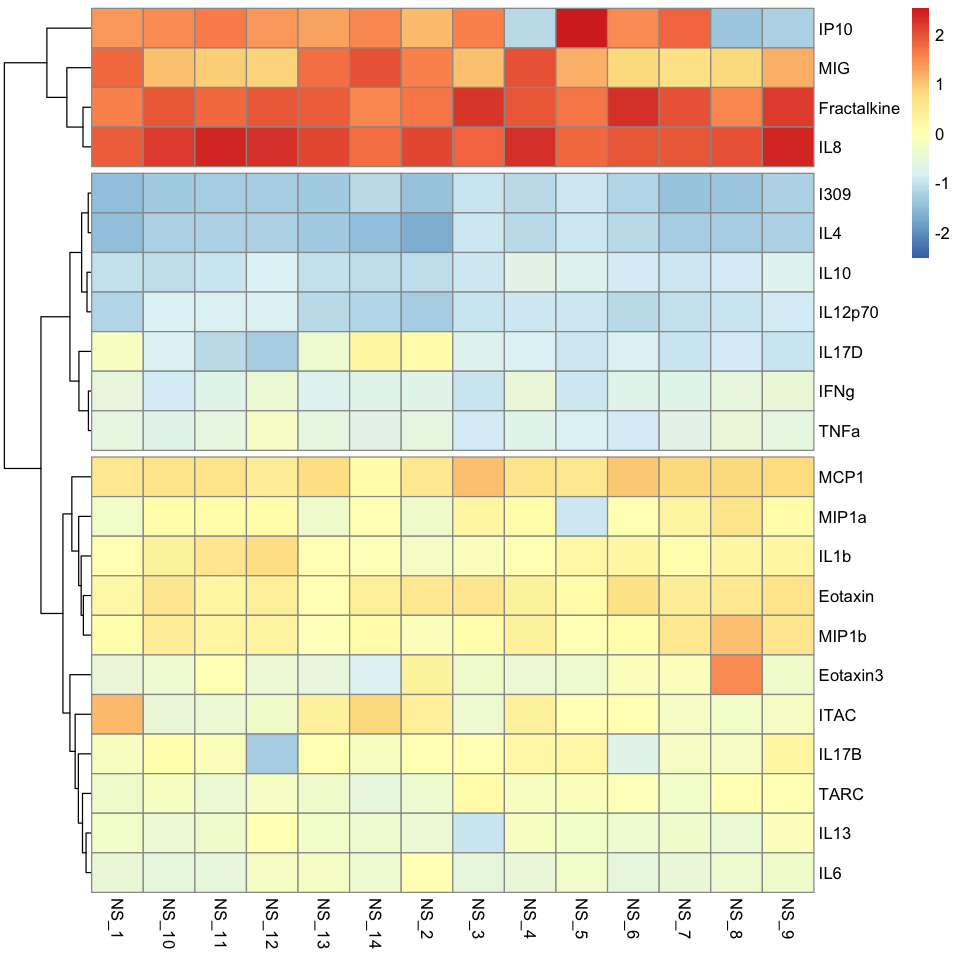

In [28]:
options(repr.plot.width=8, repr.plot.height=8) #changing size
pheatmap(t_wider_baseline_df, 
            cluster_cols = FALSE, # hierarchical clustering of cytokines
            scale = "column",    # scaling the data to make differences across cytokines more apparent
            cutree_row = 3 # adds a break bewtween the 3 largest clusters
            # angle_col = 45, fontsize_col = 7, fontsize_row = 3, # adjusting size/ orientation of axes labels
            # cellheight = 3, cellwidth = 25, # setting height and width for cells
            # border_color = FALSE # specify no border surrounding the cells
)